In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import json

In [ ]:
!wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json

In [2]:
credentials_file = "alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

In [18]:
objects_df = pd.read_parquet('data_231206/objects_with_wise_20240105.parquet')
objects_df.head()

,oid,ra,dec,submitter,alerceclass,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,...,pmDE,e_pmDE,d2M,angDist,W1-W2,W2-W3,sgscore1,distpsnr1,sgmag1,srmag1
0,ZTF21acasmne,291.414602,-14.603520,amunoz,CV/Nova,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.301667,2.888662,-999.0000,-999.0000
1,ZTF19aaonuwr,293.431251,21.348710,amunoz,LPV,J193343.50+212055.5,293.431260,21.348767,0.0336,0.0326,...,44.0,34.0,0.105,0.207602,0.038000,0.657,0.500000,0.162033,21.1831,18.5125
2,ZTF17aabhkmn,86.770569,0.308770,amunoz,YSO,J054705.00+001832.5,86.770857,0.309037,0.0359,0.0335,...,-680.0,36.0,1.293,1.412567,0.431001,1.651,0.970250,0.348792,18.7432,16.9576
3,ZTF18aatxhtl,192.578746,43.709578,amunoz,QSO,J125018.91+434234.4,192.578809,43.709580,0.1356,0.1253,...,412.0,476.0,NaN,0.162716,1.368000,2.701,0.987208,0.145086,18.8941,18.4898
4,ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn,J102618.91+183510.4,156.578829,18.586238,0.0410,0.0386,...,110.0,54.0,0.172,0.122051,0.045000,0.189,0.995595,0.351454,15.3424,14.5392


In [5]:
objects_df.shape

(41777, 38)

In [6]:
oids = ','.join([f"'{o}'" for o in objects_df['oid'].values])
print(oids[:100])

'ZTF21acasmne','ZTF19aaonuwr','ZTF17aabhkmn','ZTF18aatxhtl','ZTF18aaadfyl','ZTF21aaiaqhh','ZTF19abqg


In [7]:
query = f"select oid, sgscore1, distpsnr1, sgmag1, srmag1 from ps1_ztf where oid in ({oids});"
ans = pd.read_sql_query(query, conn)
ans

/tmp/ipykernel_25465/3766576909.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ans = pd.read_sql_query(query, conn)


,oid,sgscore1,distpsnr1,sgmag1,srmag1
0,ZTF17aaaaabj,0.992500,0.306951,16.6225,15.7968
1,ZTF17aaaaaej,0.993417,0.172447,16.7977,16.4878
2,ZTF17aaaaaej,0.993417,0.156776,16.7977,16.4878
3,ZTF17aaaaaej,0.993417,0.015943,16.7977,16.4878
4,ZTF17aaaaaej,0.993417,0.653728,16.7977,16.4878
...,...,...,...,...,...
59935,ZTF23abobwsd,0.173214,1.365892,20.3492,20.2530
59936,ZTF23abofpay,0.500000,5.491782,-999.0000,19.5914
59937,ZTF23aboxuyi,0.989792,0.274862,19.9438,19.7726
59938,ZTF23abpbdyh,0.113375,0.134416,21.4823,21.2432


In [8]:
ans_dd = ans.drop_duplicates(subset='oid')
ans_dd

,oid,sgscore1,distpsnr1,sgmag1,srmag1
0,ZTF17aaaaabj,0.992500,0.306951,16.6225,15.7968
1,ZTF17aaaaaej,0.993417,0.172447,16.7977,16.4878
6,ZTF17aaaaafz,0.905833,0.027587,19.2121,17.7368
10,ZTF17aaaaajg,0.997500,0.389268,16.9373,16.5783
12,ZTF17aaaaavq,0.886131,0.163643,20.5291,17.7606
...,...,...,...,...,...
59935,ZTF23abobwsd,0.173214,1.365892,20.3492,20.2530
59936,ZTF23abofpay,0.500000,5.491782,-999.0000,19.5914
59937,ZTF23aboxuyi,0.989792,0.274862,19.9438,19.7726
59938,ZTF23abpbdyh,0.113375,0.134416,21.4823,21.2432


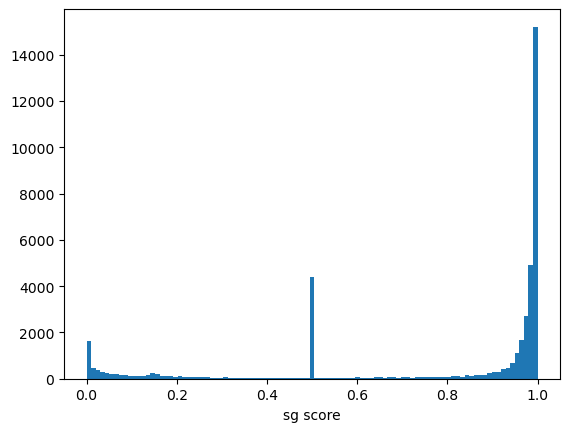

In [9]:
plt.hist(ans_dd['sgscore1'], bins=np.linspace(0, 1, 100));
plt.xlabel('sg score');

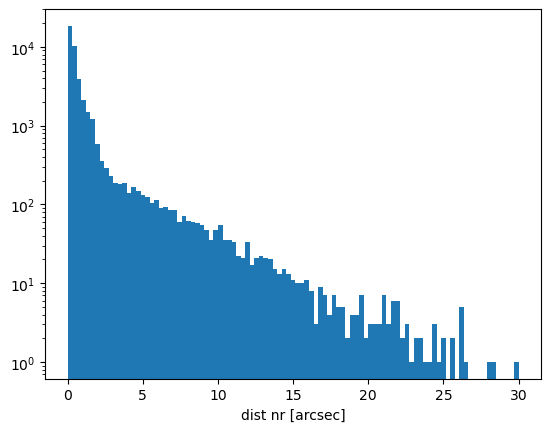

In [10]:
plt.hist(ans_dd['distpsnr1'], bins=np.linspace(0, 30, 100));
plt.semilogy();
plt.xlabel('dist nr [arcsec]');

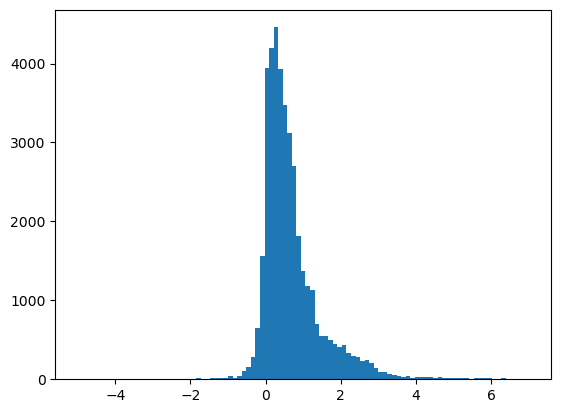

In [13]:
plt.hist(ans_dd['sgmag1'] - ans_dd['srmag1'], bins=np.linspace(-5, 7, 100));

In [14]:
ans_dd.set_index('oid', inplace=True)
objects_df.set_index('oid', inplace=True)

objects_df = pd.concat([objects_df, ans_dd], axis=1)

In [15]:
objects_df.reset_index('oid', inplace=True)
objects_df.head()

,oid,ra,dec,submitter,alerceclass,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,...,pmDE,e_pmDE,d2M,angDist,W1-W2,W2-W3,sgscore1,distpsnr1,sgmag1,srmag1
0,ZTF21acasmne,291.414602,-14.603520,amunoz,CV/Nova,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.301667,2.888662,-999.0000,-999.0000
1,ZTF19aaonuwr,293.431251,21.348710,amunoz,LPV,J193343.50+212055.5,293.431260,21.348767,0.0336,0.0326,...,44.0,34.0,0.105,0.207602,0.038000,0.657,0.500000,0.162033,21.1831,18.5125
2,ZTF17aabhkmn,86.770569,0.308770,amunoz,YSO,J054705.00+001832.5,86.770857,0.309037,0.0359,0.0335,...,-680.0,36.0,1.293,1.412567,0.431001,1.651,0.970250,0.348792,18.7432,16.9576
3,ZTF18aatxhtl,192.578746,43.709578,amunoz,QSO,J125018.91+434234.4,192.578809,43.709580,0.1356,0.1253,...,412.0,476.0,NaN,0.162716,1.368000,2.701,0.987208,0.145086,18.8941,18.4898
4,ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn,J102618.91+183510.4,156.578829,18.586238,0.0410,0.0386,...,110.0,54.0,0.172,0.122051,0.045000,0.189,0.995595,0.351454,15.3424,14.5392


In [16]:
objects_df.to_parquet('data_231206/objects_with_wise_20240105.parquet')

/home/ireyes/anaconda3/envs/pipeline/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [17]:
objects_df = pd.read_parquet('data_231206/objects_with_wise_20240105.parquet')
objects_df.head()

,oid,ra,dec,submitter,alerceclass,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,...,pmDE,e_pmDE,d2M,angDist,W1-W2,W2-W3,sgscore1,distpsnr1,sgmag1,srmag1
0,ZTF21acasmne,291.414602,-14.603520,amunoz,CV/Nova,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.301667,2.888662,-999.0000,-999.0000
1,ZTF19aaonuwr,293.431251,21.348710,amunoz,LPV,J193343.50+212055.5,293.431260,21.348767,0.0336,0.0326,...,44.0,34.0,0.105,0.207602,0.038000,0.657,0.500000,0.162033,21.1831,18.5125
2,ZTF17aabhkmn,86.770569,0.308770,amunoz,YSO,J054705.00+001832.5,86.770857,0.309037,0.0359,0.0335,...,-680.0,36.0,1.293,1.412567,0.431001,1.651,0.970250,0.348792,18.7432,16.9576
3,ZTF18aatxhtl,192.578746,43.709578,amunoz,QSO,J125018.91+434234.4,192.578809,43.709580,0.1356,0.1253,...,412.0,476.0,NaN,0.162716,1.368000,2.701,0.987208,0.145086,18.8941,18.4898
4,ZTF18aaadfyl,156.578799,18.586220,amunoz,RSCVn,J102618.91+183510.4,156.578829,18.586238,0.0410,0.0386,...,110.0,54.0,0.172,0.122051,0.045000,0.189,0.995595,0.351454,15.3424,14.5392
